# World Wide Wine Society Classifier

Ian Kollipara

CS 392 Seminar for Data Science

2022.03.16

In [48]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [49]:
df = pd.read_csv("Red Wine.csv", sep=";")

## Preprocessing
### Data Exploration

This dataset was interesting, as the wine distribution seemed to form a discrete bell curve. This observation proved useful later on. However, this observation can be seen below.

Text(0.5, 1.0, 'Distribution of Wine Quality Ratings')

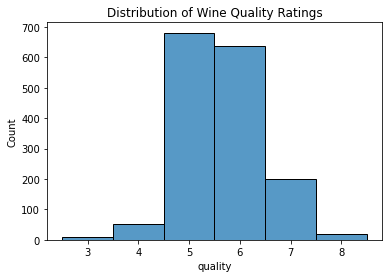

In [50]:
quality_dist_plot = sns.histplot(df, x="quality", discrete=True)
quality_dist_plot.set_title("Distribution of Wine Quality Ratings")

Besides simply noting the aformentioned observation, an important feature was "Volatile Acidity", as accordin to Zoecklein, "volatile acidity is used routinely as an indicator of wine spoilage" (2011). This fact led to the graph below. The regression line isn't as clean as it could be, due to the fact that Quality is a discrete value.


Text(0.5, 1.0, 'Quality vs. Volatile Acidity')

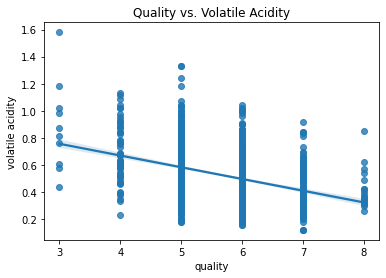

In [51]:
q_vs_va_plot = sns.regplot(x="quality", y="volatile acidity", data=df)
q_vs_va_plot.set_title("Quality vs. Volatile Acidity")

The last addition was that of another feature: Bound Sulfur Dioxide. According to Savits:
> Sulfur dioxide is used in winemaking as a preservative to prevent oxidation and microbial spoilage. It exists in three forms; bisulfite (HSO3-), molecular SO2, and sulfite (SO32). The equilibrium is pH dependent with the predominate form at wine pH being bisulfite. Most of the rest is molecular and very little, if any, remains in sulfite form. These forms make up what is termed as ‘free SO2’. Free SO2 can be lost through volatilization or binding, thus management is important. A target of 0.6-0.8 mg/L (ppm) molecular SO2 has been deemed sufficient to keep wine protected. (2019)

![image.png](https://www.extension.iastate.edu/wine/wp-content/uploads/2019/04/jennie_newsletter_pic.png) 

(Savits, 2019)

All of this to say, this column addition added some value and better predictions for the model, as seen further down.

In [52]:
df["bound sulfur dioxide"] = df["total sulfur dioxide"] - df["free sulfur dioxide"]

### Binary Classification Transformation

For creating the binary classification, as noted above the bell curve indicates that a majority of the wine lies at $5\geq$, as such I chose this as the boundary of whether a wine is considered "good". This chose was made in the mindset to optimize for recall, as more will be considered good - which means that a majority will pass through. This choice yields good results, as seen further down.

In [53]:
df["quality"] = df["quality"].apply(lambda q: 0 if q < 5 else 1)

## Classification

### Creating Test Data

In [54]:
# This code is adapted from https://blackboard.cune.edu/bbcswebdav/pid-1545189-dt-content-rid-14535247_1/courses/CS-392-01_202220/ClassificationTutorial.html
X = df.drop("quality", axis=1)
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

### K-Nearest Neighbors

This model is an instance-based model. What that translates to is the data itself comprises the model. Predictions are then made based on the $K$ nearest neighbor points, hence the name. This $K$ is a variable, and can change. This model is quite slow at predictions and doesn't really scale well to large datasets, as such it I don't highly recommend it.

In terms of hyperparameter tuning, I tested a range of $K$ values, going from 3-7. This range is built around SKLearn's default of 5. Ultimately, as seen below, 5 is the best option.

In [55]:
for i in range(3, 8):
    kmodel = KNeighborsClassifier(i)
    kmodel.fit(X_train, y_train)
    
    y_pred = kmodel.predict(X_test)
    print(f"K={i}")
    print(confusion_matrix(y_test, y_pred))
    print()

K=3
[[  1  14]
 [  1 384]]

K=4
[[  1  14]
 [  2 383]]

K=5
[[  0  15]
 [  0 385]]

K=6
[[  0  15]
 [  1 384]]

K=7
[[  0  15]
 [  0 385]]



Given we have a strong model, we can then test using normal metrics. These metrics will be compared against each other in the conclusion.

The metrics chosen are:
- Accuracy
- Precision
- Recall
- F1 Score

These 4 build a strong basis on which we can compare the models. As Accuracy is a simple metric, tellin how well each prediction was. Precision focuses on how well the model avoids false positivies, that is values that shouldn't be "good", but were classified as such. Recall is the oppisite direction, focusing on avoiding false negatives, that is values that were classified as "bad", when they were not. This metics is the key one to look at, as it makes sure "no good wine goes unnoticed". The last is F$_1$ Score, which balances Precision and Recall against each other - providing a smarter Accuracy measurement.

In [56]:
kmodel = KNeighborsClassifier().fit(X_train, y_train)
y_pred = kmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score_ = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score_}")

Accuracy: 0.9625
Precision: 0.9625
Recall: 1.0
F1 Score: 0.980891719745223


These results show the optimization for Recall was a smart choice. Besides that, many of the metrics show strong results. The fear of overfitting is then squashed by the `cross_val_score` which shows the model does well against all values in the dataset.

In [57]:
for i in range(4, 11):
    print(f"cv={i}")
    print(cross_val_score(kmodel, X, y, cv=i))
    print()

cv=4
[0.96       0.96       0.945      0.96491228]

cv=5
[0.9625     0.959375   0.959375   0.95       0.96238245]

cv=6
[0.9588015  0.9588015  0.9588015  0.94736842 0.96240602 0.96240602]

cv=7
[0.96069869 0.96069869 0.96069869 0.96052632 0.95175439 0.96052632
 0.96052632]

cv=8
[0.96       0.96       0.96       0.96       0.95       0.95
 0.96       0.96482412]

cv=9
[0.96067416 0.96067416 0.96067416 0.96067416 0.96067416 0.94382022
 0.96045198 0.96045198 0.96045198]

cv=10
[0.9625     0.9625     0.9625     0.9625     0.9625     0.95
 0.94375    0.95625    0.95625    0.96226415]



Although this model yields strong results, as stated before it doesn't scale well. The reason comes down to the prediction phase, which grows larger when the dataset grows larger. Given this, the next model used wil be Decision Trees.

### Decision Trees

Decision Trees are model-based predictors. This means the fitting stage is far more work, but predictting is far faster. The Decision Tree is a greedy algorithm that makes chooses paths that result in the most Information Gain. This statistic is calculated based off entropy - or something entropy adjecent. After all these choices are made, the result is a tree of nested choices that result in classification. Decision Trees are infamous for overfitting, given their nature.

To address this overfitting, I played with the `max_depth` hyperparameter, testing a range of 1-10. This parameter was chosen over others as it forces a hard stop to the tree. 

In [58]:
for i in range(1, 11):
    dt_model = DecisionTreeClassifier(max_depth=i)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    print(f"max_depth={i}")
    print(confusion_matrix(y_test, y_pred))
    print()

max_depth=1
[[  0  15]
 [  0 385]]

max_depth=2
[[  0  15]
 [  1 384]]

max_depth=3
[[  2  13]
 [  8 377]]

max_depth=4
[[  1  14]
 [  4 381]]

max_depth=5
[[  1  14]
 [  3 382]]

max_depth=6
[[  1  14]
 [  3 382]]

max_depth=7
[[  2  13]
 [  8 377]]

max_depth=8
[[  2  13]
 [ 11 374]]

max_depth=9
[[  1  14]
 [  7 378]]

max_depth=10
[[  2  13]
 [  7 378]]



The above results show `max_depth = 5` to be the strongest model. This choice was made to have plenty of depth to allow for actual choice, but to optimize for recall, as it has the smallest of those greater than 2. I did not chose `max_depth = 1` or `max_depth = 2`, as those aren't full trees. The results weren't as strong as before for testing, but I prefere the decision tree to K-Nearest Neighbors due to the scaling factor.

The aformentioned metrics are again used here, showing that the optimization for recall wasn't as strong as compared to the previous model.

In [59]:
dt_model = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred)
f1_score1 = f1_score(y_test, y_pred)

precision0 = precision_score(y_test, y_pred, pos_label=0)
recall0 = recall_score(y_test, y_pred, pos_label=0)
f1_score0 = f1_score(y_test, y_pred, pos_label=0)

print(f"Accuracy: {accuracy}")
print("Metrics for Class = 1 (Good)")
print(f"    Precision: {precision1}")
print(f"    Recall: {recall1}")
print(f"    F1-Score: {f1_score1}")
print("----------------------------")
print("Metrics for Class = 0 (Bad)")
print(f"    Precision: {precision0}")
print(f"    Recall: {recall0}")
print(f"    F0-Score: {f1_score0}")
print()

for i in range(4, 11):
    print(f"cv={i}")
    print(cross_val_score(dt_model, X, y, cv=i))
    print()

Accuracy: 0.9575
Metrics for Class = 1 (Good)
    Precision: 0.9646464646464646
    Recall: 0.9922077922077922
    F1-Score: 0.9782330345710627
----------------------------
Metrics for Class = 0 (Bad)
    Precision: 0.25
    Recall: 0.06666666666666667
    F0-Score: 0.10526315789473685

cv=4
[0.95       0.95       0.9475     0.94736842]

cv=5
[0.953125   0.959375   0.91875    0.953125   0.94043887]

cv=6
[0.94007491 0.96254682 0.91011236 0.92481203 0.95864662 0.93609023]

cv=7
[0.94323144 0.96069869 0.95633188 0.91666667 0.92982456 0.95614035
 0.93421053]

cv=8
[0.935      0.96       0.955      0.89       0.955      0.945
 0.96       0.96482412]

cv=9
[0.92134831 0.96067416 0.9494382  0.95505618 0.9494382  0.90449438
 0.96045198 0.95480226 0.96045198]

cv=10
[0.90625    0.9625     0.9625     0.95625    0.90625    0.96875
 0.9125     0.95625    0.95       0.94339623]



The metrics show a model designed for recall. As seen in the 0 - or "bad" - case, the model wasn't strong at identifing bad wine. It followed the purpose of discovering good wine for more. This is an inherent result of a Decision Tree, as it was trained and fitted for that. To overcome some of these issues, and to provide potentially the best algorithm for classification, the last model is Random Forest.

### Random Forests 

A Random Forest is simply a collection of Decision Trees, meaning more are tested and overfitting is better addressed. This model is by far the slowest to fit, but is just as fast as Decision Trees in predicting. In regards to hyperparameter tuning, I did the same as Decision Trees. I see Random Forest as a better version of Decision Trees, and as such I didn't feel a need to adjust what I was doing in the previous version.

In [60]:
for i in range(1, 11):
    rf_model = RandomForestClassifier(max_depth=i)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    print(f"max_depth={i}")
    print(confusion_matrix(y_test, y_pred))
    print()

max_depth=1
[[  0  15]
 [  0 385]]

max_depth=2
[[  0  15]
 [  0 385]]

max_depth=3
[[  0  15]
 [  0 385]]

max_depth=4
[[  0  15]
 [  0 385]]

max_depth=5
[[  0  15]
 [  0 385]]

max_depth=6
[[  1  14]
 [  0 385]]

max_depth=7
[[  1  14]
 [  1 384]]

max_depth=8
[[  0  15]
 [  0 385]]

max_depth=9
[[  0  15]
 [  0 385]]

max_depth=10
[[  0  15]
 [  0 385]]



From this we can see that a `max_depth = 8` yields a strong model. This is different than Decision Trees and part of that is a result of what happens with Random Forest. This particular model also yielded the most True Positives.

Using the usual metrics, we see the following results:

In [67]:
rf_model = RandomForestClassifier(max_depth=8).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred)
f1_score1 = f1_score(y_test, y_pred)

precision0 = precision_score(y_test, y_pred, pos_label=0, zero_division=1)
recall0 = recall_score(y_test, y_pred, pos_label=0)
f1_score0 = f1_score(y_test, y_pred, pos_label=0)

print(f"Accuracy: {accuracy}")
print("Metrics for Class = 1 (Good)")
print(f"    Precision: {precision1}")
print(f"    Recall: {recall1}")
print(f"    F1-Score: {f1_score1}")
print("----------------------------")
print("Metrics for Class = 0 (Bad)")
print(f"    Precision: {precision0}")
print(f"    Recall: {recall0}")
print(f"    F1-Score: {f1_score0}")
print()

for i in range(4, 11):
    print(f"cv={i}")
    print(cross_val_score(rf_model, X, y, cv=i))
    print()

Accuracy: 0.965
Metrics for Class = 1 (Good)
    Precision: 0.9649122807017544
    Recall: 1.0
    F1-Score: 0.9821428571428572
----------------------------
Metrics for Class = 0 (Bad)
    Precision: 1.0
    Recall: 0.06666666666666667
    F1-Score: 0.125

cv=4
[0.955      0.9575     0.9575     0.96240602]

cv=5
[0.95625    0.959375   0.959375   0.959375   0.96238245]

cv=6
[0.95131086 0.9588015  0.9588015  0.96240602 0.96616541 0.96240602]

cv=7
[0.94759825 0.96069869 0.95633188 0.96491228 0.96052632 0.96052632
 0.96052632]

cv=8
[0.95       0.965      0.96       0.965      0.96       0.96
 0.965      0.96482412]

cv=9
[0.94382022 0.96067416 0.96067416 0.96067416 0.96067416 0.96067416
 0.96045198 0.96045198 0.96045198]

cv=10
[0.95       0.96875    0.9625     0.9625     0.95625    0.9625
 0.95625    0.95625    0.95625    0.96226415]



These results show a model that competes well with K-Nearest Neighbors, but scales far more. Random Forest has all the benefits of Decision Trees, but addresses many of the drawbacks. Given this, and the fact is scales better, I recommend this model. 

## Conclusion

All of the models did well with the training and test sets, and all of them had high Cross Validation Scores and high Recall scores. However, I would recommend Random Forest due to scaling, and overfitting. K-Nearest Neighbors has all of the processing in the predict phase, which scales with the amount of data objects. This isn't ideal as it results in exceptionally slow predictions on mediore sized datasets. Decision Trees are prone to overfitting, however are far better in the prediction phase. Random Forest has these benefits, but address these overfitting problems. The model showed great results, as seen in its statistics section, but is also designed to scale better against larger datasets. 

## References
Savits, J. (2019, April 26). Sulfur Dioxide Measurement and Overestimation in Red Wine. Midwest Grape and Wine Industry Institute. https://www.extension.iastate.edu/wine/sulfur-dioxide-measurement-and-overestimation-red-wine/
Zoecklein, B. (2011, June 29). Enology Notes #158. Wine / Enology Grape Chemistry Group. https://www.apps.fst.vt.edu/extension/enology/EN/158.html#2
